
# Factor Investing - Fixed Income
### Alejandro Valbuena Núñez

In [1]:
# Carga de librerias
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from datetime import timedelta


## EDA - LF98TRUU Index 2013 - 2023
### Bloomberg US Corporate High Yield Total Return Index Value Unhedged USD
Este índice mide el rendimiento total de los bonos corporativos de alto rendimiento (high yield) emitidos en los Estados Unidos. Los bonos de alto rendimiento son aquellos que tienen una calificación crediticia más baja y, por lo tanto, ofrecen rendimientos más altos para compensar el mayor riesgo. Este índice no está cubierto contra las fluctuaciones de la moneda, lo que significa que refleja el rendimiento en términos del dólar estadounidense sin protegerse contra la volatilidad cambiaria.

In [2]:
# Se cargan los datos, se concatenan ambos excel y se limpian creando Month para temporalidad

file_path_2013 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LF98TRUU/LF98TRUU Index 2013.xlsx'
file_path_2014_2023 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LF98TRUU/LF98TRUU Index (2014-2023).xlsb'

def load_excel_file(file_path):
    xls = pd.ExcelFile(file_path)
    df_list = []
    
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        df['Month'] = sheet_name 
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df


data_2013 = load_excel_file(file_path_2013)

def load_xlsb_file(file_path):
    xls = pd.ExcelFile(file_path, engine='pyxlsb')
    df_list = []
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name, engine='pyxlsb')
        df['Month'] = sheet_name
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df


data_2014_2023 = load_xlsb_file(file_path_2014_2023)

hYield = pd.concat([data_2013, data_2014_2023], ignore_index=True)


In [3]:
# Convertir 'Month' a formato de fecha

hYield['Month'] = pd.to_datetime(hYield['Month'], format='%b %d %Y')

In [4]:
hYield.head()

,ISIN,Description,Ccy,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Issuer,Maturity,Maturity.1,Index Rating (String),BCLASS 2,Cpn,Payment rank,Month
0,US852061AK63,S 9 11/15/18,USD,124.500,4.209298,4.750172,3000000.0,3.783000e+06,0.325330,4.209298,SPRINT COMMUNICATIONS INC,5.822222,11/15/2018,BA3,INDUSTRIAL,9.000,Sr Unsecured,2013-01-18
1,US404121AC95,HCA 6 ½ 02/15/20,USD,113.750,4.229491,5.778464,3000000.0,3.495917e+06,0.300641,4.229491,HCA INC,7.072222,02/15/2020,BA2,INDUSTRIAL,6.500,1st lien,2013-01-18
2,US761735AN93,PTVE 5 ¾ 10/15/20,USD,103.750,4.988087,5.283333,3250000.0,3.429495e+06,0.294929,5.154282,REYNOLDS GRP ISS/REYNOLD,7.738889,10/15/2020,B1,INDUSTRIAL,5.750,1st lien,2013-01-18
3,US319963BB96,FDC 12 ⅝ 01/15/21,USD,107.250,11.105545,5.113684,2999994.0,3.411077e+06,0.293345,11.226144,FIRST DATA CORP,7.988889,01/15/2021,CAA1,INDUSTRIAL,12.625,Sr Unsecured,2013-01-18
4,US458204AH70,INTEL 11 ¼ 02/04/17,USD,106.125,4.812095,0.084089,2805000.0,3.111797e+06,0.267608,9.390606,INTELSAT LUXEMBOURG SA,4.041667,02/04/2017,CAA3,INDUSTRIAL,11.250,Sr Unsecured,2013-01-18


In [8]:
# Se eliminan las columnas que no aportan información relevante
hYield = hYield.drop(columns=['Description'], errors='ignore')
hYield = hYield.drop(columns=['Ccy'], errors='ignore')

In [6]:
hYield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259757 entries, 0 to 259756
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ISIN                   259757 non-null  object        
 1   Price                  259757 non-null  float64       
 2   YTW                    259757 non-null  float64       
 3   OAD                    259757 non-null  float64       
 4   Par Val                259757 non-null  float64       
 5   MV                     259757 non-null  float64       
 6   Weight                 259757 non-null  float64       
 7   Yield to Maturity      259757 non-null  float64       
 8   Issuer                 259757 non-null  object        
 9   Maturity               259757 non-null  float64       
 10  Maturity.1             259757 non-null  object        
 11  Index Rating (String)  259757 non-null  object        
 12  BCLASS 2               259757 non-null  obje

In [126]:
hYield.isna().sum()

ISIN                     0
Price                    0
YTW                      0
OAD                      0
Par Val                  0
MV                       0
Weight                   0
Yield to Maturity        0
Issuer                   0
Maturity                 0
Maturity.1               0
Index Rating (String)    0
BCLASS 2                 0
Cpn                      0
Payment rank             0
Month                    0
dtype: int64

In [127]:
hYield.shape

(259757, 16)

### Preparación para el análisis

In [130]:
# Normalizacion de las columnas numericas
numeric_cols = hYield.select_dtypes(include=['float64']).columns
print(f"Columnas numéricas: {numeric_cols}")

scaler = StandardScaler()
hYield[numeric_cols] = scaler.fit_transform(hYield[numeric_cols])

hYield.head()

Columnas numéricas: Index(['Price', 'YTW', 'OAD', 'Par Val', 'MV', 'Weight', 'Yield to Maturity',
       'Maturity', 'Cpn'],
      dtype='object')


,ISIN,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Issuer,Maturity,Maturity.1,Index Rating (String),BCLASS 2,Cpn,Payment rank,Month
0,US852061AK63,1.560277,-0.190790,0.386225,5.054117,6.470922,7.668153,-0.214683,SPRINT COMMUNICATIONS INC,-0.080218,11/15/2018,BA3,INDUSTRIAL,1.321355,Sr Unsecured,2013-01-18
1,US404121AC95,0.947340,-0.189638,0.816372,5.054117,5.879888,6.986164,-0.213526,HCA INC,0.203476,02/15/2020,BA2,INDUSTRIAL,-0.050773,1st lien,2013-01-18
2,US761735AN93,0.377165,-0.146372,0.609252,5.588872,5.743141,6.828373,-0.160551,REYNOLDS GRP ISS/REYNOLD,0.354780,10/15/2020,B1,INDUSTRIAL,-0.462411,1st lien,2013-01-18
3,US319963BB96,0.576726,0.202530,0.538286,5.054104,5.705223,6.784619,0.187269,FIRST DATA CORP,0.411519,01/15/2021,CAA1,INDUSTRIAL,3.310941,Sr Unsecured,2013-01-18
4,US458204AH70,0.512582,-0.156410,-1.565655,4.637008,5.089079,6.073655,0.082122,INTELSAT LUXEMBOURG SA,-0.484326,02/04/2017,CAA3,INDUSTRIAL,2.556271,Sr Unsecured,2013-01-18


In [131]:
hYield.describe()

,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Maturity,Cpn,Month
count,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,2.597570e+05,259757
mean,-4.131568e-16,7.877990e-17,-1.953085e-16,1.378648e-17,1.654378e-16,-4.595494e-18,-6.389925e-17,1.930108e-16,-1.838198e-16,2018-02-22 22:38:58.114468608
min,-5.538393e+00,-6.375950e+00,-5.873275e+00,-1.042091e+00,-1.317349e+00,-1.318669e+00,-2.385259e+00,-1.186628e+00,-3.618305e+00,2013-01-18 00:00:00
25%,-1.074827e-01,-1.868946e-01,-6.876546e-01,-6.142869e-01,-6.317811e-01,-6.260575e-01,-1.778812e-01,-5.158472e-01,-7.368367e-01,2015-07-17 00:00:00
50%,2.488762e-01,-1.111721e-01,-9.521497e-02,-2.934339e-01,-2.784390e-01,-2.884690e-01,-1.103085e-01,-1.464136e-01,-1.193791e-01,2018-01-19 00:00:00
75%,4.557924e-01,-2.396757e-03,4.839846e-01,2.413212e-01,2.740319e-01,2.675658e-01,-1.024760e-02,2.406720e-01,6.352913e-01,2020-10-19 00:00:00
max,4.243289e+00,1.860082e+02,7.393299e+00,9.738572e+00,1.071539e+01,1.135430e+01,1.868006e+02,1.768916e+01,5.986591e+00,2023-04-19 00:00:00
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,NaN


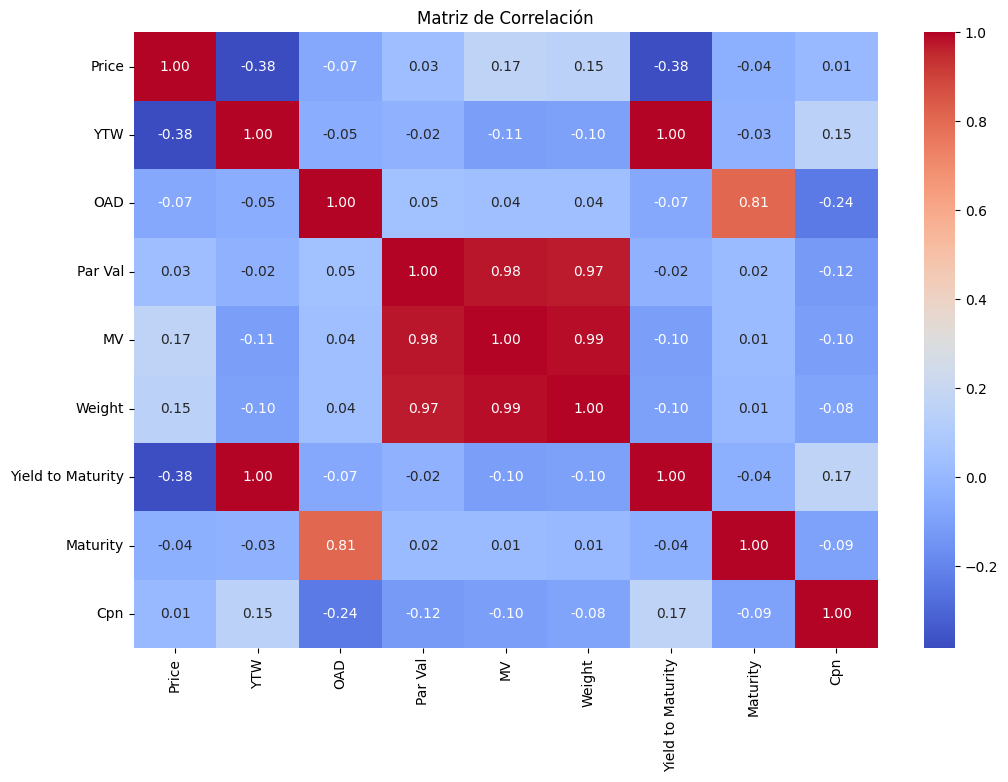

In [133]:
# Matriz de correlación
numeric_cols = ['Price', 'YTW', 'OAD', 'Par Val', 'MV', 'Weight', 'Yield to Maturity', 'Maturity', 'Cpn']
correlation_matrix = hYield[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


In [134]:
# Dividir los datos en conjuntos de entrenamiento y test

numeric_cols = ['OAD', 'Par Val', 'MV', 'Weight', 'Maturity', 'Cpn']
categorical_cols = ['Issuer', 'Index Rating (String)', 'BCLASS 2', 'Payment rank']

X = hYield[numeric_cols + categorical_cols]
y = hYield['Yield to Maturity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Factor Analysis - YTM - Modelos

Mean Squared Error: 0.0921663172061907
R-squared: 0.9050416318164811
    Feature  Importance
0       OAD    0.144371
1   Par Val    0.156595
2    Weight    0.467057
3  Maturity    0.094277
4       Cpn    0.137701


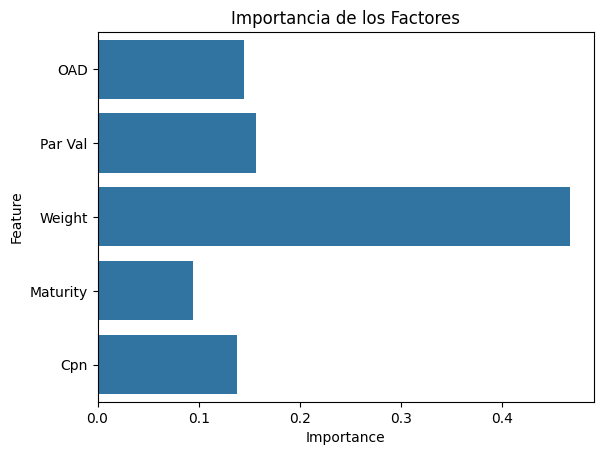

In [137]:
features = ['OAD', 'Par Val', 'Weight', 'Maturity', 'Cpn']
X = hYield[features]
y = hYield['Yield to Maturity']

# Entrenamiento del modelo de Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluación del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

importances = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
print(feature_importance)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Importancia de los Factores')
plt.show()

Mean Squared Error: 0.11229292645423015
R-squared: 0.8843053148061626
                       Feature  Importance
2                       Weight    0.460394
0                          OAD    0.131747
4                          Cpn    0.130897
1                      Par Val    0.124720
3                     Maturity    0.085173
17    Index Rating (String)_CA    0.013328
16     Index Rating (String)_C    0.009097
20  Index Rating (String)_CAA3    0.008187
27       Payment rank_1.5 Lien    0.007768
21     Index Rating (String)_D    0.006043


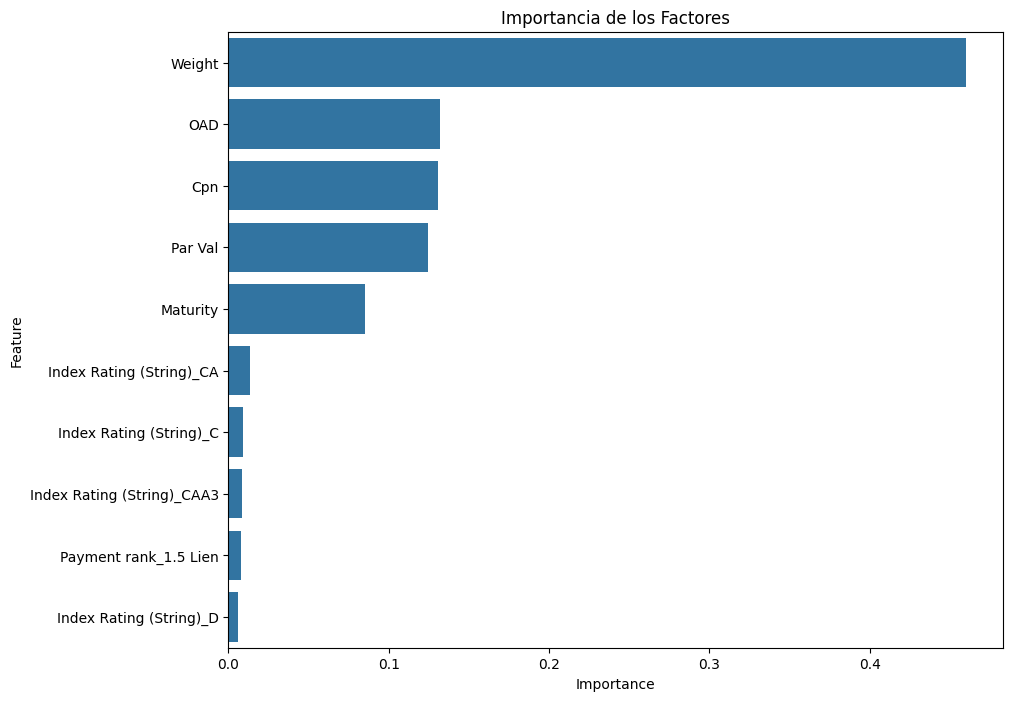

In [108]:
numeric_cols = ['OAD', 'Par Val', 'Weight', 'Maturity', 'Cpn']
categorical_cols = ['Index Rating (String)', 'BCLASS 2', 'Payment rank']

X = hYield[numeric_cols + categorical_cols]
y = hYield['Yield to Maturity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

ohe_feature_names = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, ohe_feature_names])
importances = pipeline.named_steps['model'].feature_importances_
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance.head(10)) 

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Importancia de los Factores')
plt.show()

## RNN 

Primera prueba añadiendo temporalidad

In [154]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

hYield = hYield.sort_values(by=['ISIN', 'Month'])

hYield['Momentum_3M'] = hYield.groupby('ISIN')['Yield to Maturity'].pct_change(periods=3)
hYield['YTM_Change'] = hYield.groupby('ISIN')['Yield to Maturity'].diff()
hYield['OAD_Change'] = hYield.groupby('ISIN')['OAD'].diff()
hYield['MV_Change'] = hYield.groupby('ISIN')['MV'].diff()
hYield['Weight_Change'] = hYield.groupby('ISIN')['Weight'].diff()

hYield = hYield.dropna()

numeric_cols = ['OAD', 'Par Val', 'MV', 'Weight', 'Maturity', 'Cpn', 'Momentum_3M', 'YTM_Change', 'OAD_Change', 'MV_Change', 'Weight_Change']
categorical_cols = ['Issuer', 'Index Rating (String)', 'BCLASS 2', 'Payment rank']

X = hYield[numeric_cols + categorical_cols]
y = hYield['Yield to Maturity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ])
X_processed = preprocessor.fit_transform(X)
y = hYield['Yield to Maturity'].values

print(X_processed.shape)

(183608, 3325)


In [155]:
# Crear secuencias de tiempo para LSTM y comprobar dimensiones para el modelo de después
def create_sequences(X, y, time_steps=3):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 3
X_seq, y_seq = create_sequences(X_processed, y, time_steps)
print(X_seq.shape) 

(183605, 3, 3325)


In [156]:
# Volver a hacer la división de los datos y comprobar las dimensiones
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")  
print(f"Shape of X_test: {X_test.shape}")  

Shape of X_train: (146884, 3, 3325)
Shape of X_test: (36721, 3, 3325)


In [168]:
from sklearn.model_selection import RandomizedSearchCV, KFold
import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(time_steps, X_train.shape[2])))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(LSTM(units=hp.Int('units_' + str(i),
                                    min_value=32,
                                    max_value=256,
                                    step=32),
                       activation='relu',
                       return_sequences=True if i < hp.Int('num_layers', 1, 3) - 1 else False))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i),
                                        min_value=0.2,
                                        max_value=0.5,
                                        step=0.1)))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=10,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='intro_to_kt')

tuner.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)
model.summary()

# Entrenar el mejor modelo
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Trial 60 Complete [00h 17m 34s]
val_loss: 1.117294192314148

Best val_loss So Far: 0.38397035002708435
Total elapsed time: 09h 20m 44s


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 96)             │     1,314,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,314,145 (5.01 MB)

 Trainable params: 1,314,145 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 1.3435 - mae: 0.1776 - val_loss: 0.5119 - val_mae: 0.1322
Epoch 2/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 216s 47ms/step - loss: 1.8563 - mae: 0.1592 - val_loss: 0.4644 - val_mae: 0.1329
Epoch 3/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 100s 22ms/step - loss: 0.8221 - mae: 0.1467 - val_loss: 0.5828 - val_mae: 0.1477
Epoch 4/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.7767 - mae: 0.1383 - val_loss: 0.4682 - val_mae: 0.1238
Epoch 5/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 114s 25ms/step - loss: 0.8752 - mae: 0.1388 - val_loss: 0.4351 - val_mae: 0.1387
Epoch 6/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.4697 - mae: 0.1300 - val_loss: 0.6242 - val_mae: 0.1312
Epoch 7/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - loss: 0.5253 - mae: 0.1285 - val_loss: 0.4219 - val_mae: 0.1212
Epoch 8/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - loss: 0.5156 - mae: 0.1236 - val_loss: 0.4880 - val_mae: 0.1230
Epoch 9/10
4591/4591 ━━━━━

1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3848 - mae: 0.1201
Mean Absolute Error on test data: 0.1211811900138855
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error on test data: 0.42191452235754184
Root Mean Squared Error on test data: 0.6495494764508257
R-squared on test data: 0.6231840484284701


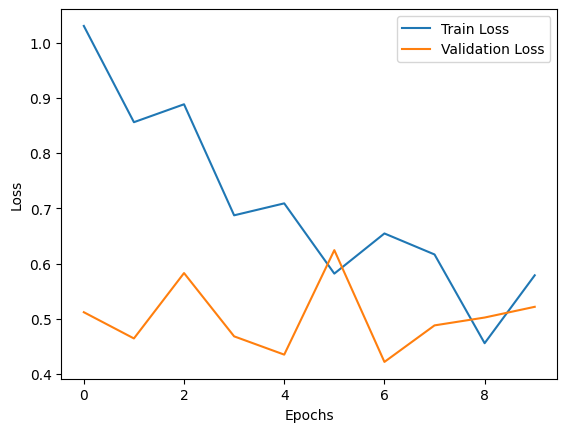

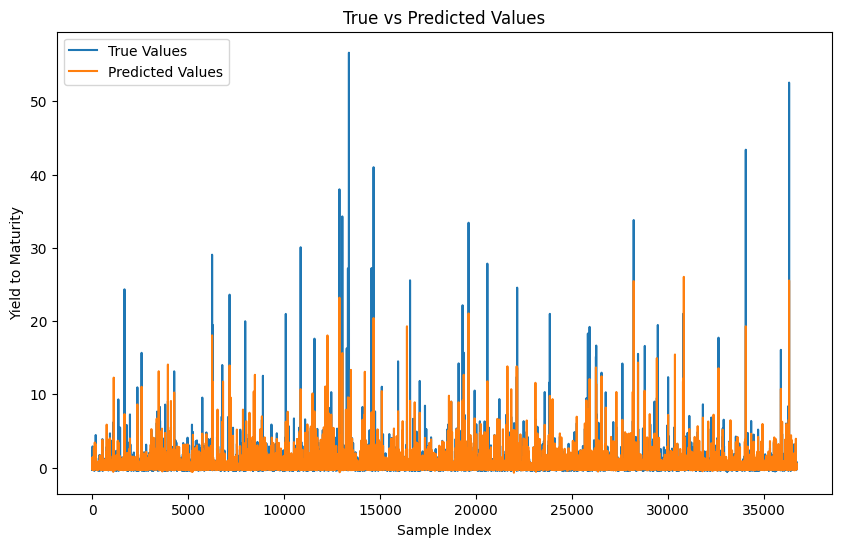

In [169]:
# Evaluar el modelo
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test data: {mae}')
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test data: {mse}')
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on test data: {rmse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared on test data: {r2}')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Yield to Maturity')
plt.legend()
plt.show()

In [170]:
# Modelo sin temporalidad

model = Sequential()
model.add(InputLayer(input_shape=(time_steps, X_train.shape[2])))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 3, 64)          │       867,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 880,289 (3.36 MB)

 Trainable params: 880,289 (3.36 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 1.0490 - mae: 0.1772 - val_loss: 0.5819 - val_mae: 0.1361
Epoch 2/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 30s 7ms/step - loss: 0.8347 - mae: 0.1554 - val_loss: 0.6222 - val_mae: 0.1447
Epoch 3/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 0.7604 - mae: 0.1578 - val_loss: 0.7017 - val_mae: 0.1309
Epoch 4/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.4871 - mae: 0.1385 - val_loss: 0.6014 - val_mae: 0.1465
Epoch 5/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.6109 - mae: 0.1436 - val_loss: 0.4338 - val_mae: 0.1271
Epoch 6/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.6193 - mae: 0.1353 - val_loss: 0.6372 - val_mae: 0.1197
Epoch 7/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - loss: 1.0761 - mae: 0.1361 - val_loss: 0.4657 - val_mae: 0.1200
Epoch 8/10
4591/4591 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - loss: 0.5042 - mae: 0.1304 - val_loss: 0.4474 - val_mae: 0.1239
Epoch 9/10
4591/4591 ━━━━━━━━━━━

1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3843 - mae: 0.1250
Mean Absolute Error on test data: 0.12705595791339874
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Mean Squared Error on test data: 0.43382356815386275
Root Mean Squared Error on test data: 0.6586528434265374
R-squared on test data: 0.6125479641359111


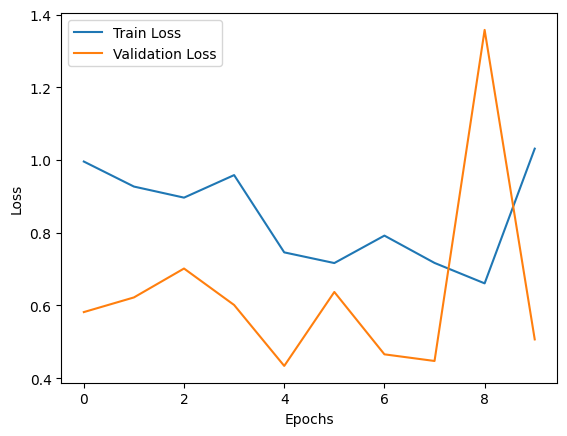

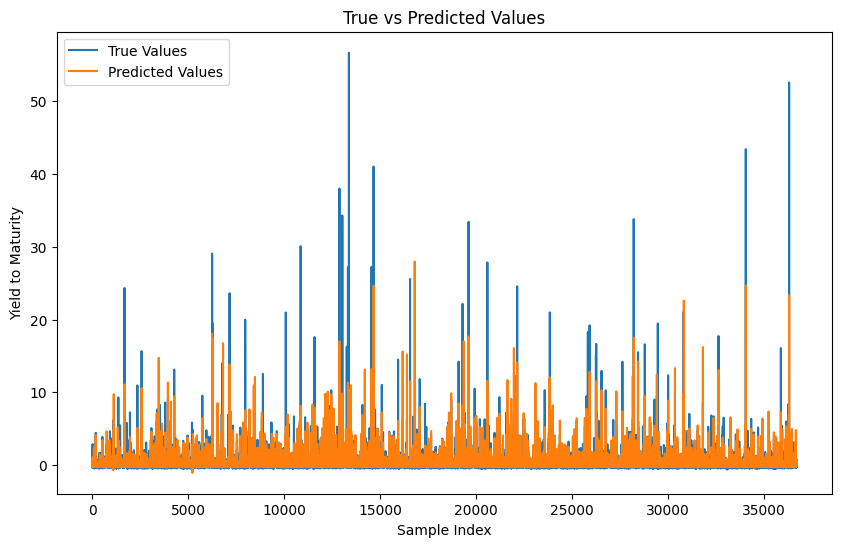

In [172]:
from sklearn.metrics import mean_squared_error, r2_score

loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error on test data: {mae}')

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error on test data: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on test data: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared on test data: {r2}')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predicted Values')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Yield to Maturity')
plt.legend()
plt.show()

## MIC

In [138]:
from minepy import MINE
import numpy as np

ytm = hYield['Yield to Maturity']

datos_numericos = hYield.select_dtypes(include=[np.number])

mine = MINE()

mic_scores = {}
for column in datos_numericos.columns:
    mine.compute_score(datos_numericos[column], ytm)
    mic_scores[column] = mine.mic()

for column, mic in sorted(mic_scores.items(), key=lambda item: item[1], reverse=True):
    print(f"{column}: MIC = {mic}")


Yield to Maturity: MIC = 0.9999999999893122
YTW: MIC = 0.7597523827497041
Price: MIC = 0.32401984146156837
Cpn: MIC = 0.23428524886516194
Par Val: MIC = 0.148701550478682
Maturity: MIC = 0.09241947421702791
MV: MIC = 0.08003249271003052
Weight: MIC = 0.06442443128181853
OAD: MIC = 0.057829114310779924


MIC: Coeficiente de información máxima, mide la dependencia entre dos variables. En este caso, cada variable del dataset y su dependencia con YTM.

## Integración de todos los bonos

## LUACTRUU Index 2013 - 2023
### Bloomberg US Corporate Total Return Value Unhedged USD
Este índice mide el rendimiento total de los bonos corporativos emitidos en los Estados Unidos. Este índice no está cubierto contra las fluctuaciones de la moneda, lo que significa que refleja el rendimiento en términos del dólar estadounidense sin protegerse contra la volatilidad cambiaria.

In [4]:
file_path_2013_15 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LUACTRUU/LUACTRUU Index Data (2015-2013).xlsx'
file_path_2016 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LUACTRUU/LUUACTRUU Index 2017-2016.xlsx'
file_path_2018 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LUACTRUU/LUACTRUU Index 2018-2020.xlsx'
file_path_2021 = '/Users/alejandrovalbuena/Desktop/ICAI/23:24/Cuatri 2/TFG - Analytics/LUACTRUU/LUACTRUU Index 2023-2021 (1).xlsx'

def load_excel_file(file_path):
    xls = pd.ExcelFile(file_path)
    df_list = []
    
    for sheet_name in xls.sheet_names:
        df = pd.read_excel(xls, sheet_name=sheet_name)
        df['Month'] = sheet_name 
        df_list.append(df)

    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

data_2013_15 = load_excel_file(file_path_2013_15)
data_2016 = load_excel_file(file_path_2016)
data_2018 = load_excel_file(file_path_2018)
data_2021 = load_excel_file(file_path_2021)

new_bonds = pd.concat([data_2013_15,data_2016, data_2018, data_2021], ignore_index=True)


In [5]:
new_bonds = new_bonds.dropna(subset=['ISIN'])

In [6]:
new_bonds.isna().sum()

ISIN                     0
Description              0
Ccy                      0
Price                    0
YTW                      0
OAD                      0
Par Val                  0
MV                       0
Weight                   0
Yield to Maturity        0
Issuer                   0
Maturity                 0
Maturity.1               0
Index Rating (String)    0
BCLASS 2                 0
Cpn                      0
Payment rank             0
Month                    0
dtype: int64

In [8]:
new_bonds.head()

,ISIN,Description,Ccy,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Issuer,Maturity,Maturity.1,Index Rating (String),BCLASS 2,Cpn,Payment rank,Month
0,US035242AN64,ABIBB 4.9 02/01/46,USD,112.306,4.146142,15.783,11000000,12606689.0,0.245183,4.152812,ANHEUSER-BUSCH INBEV FIN,28.030556,02/01/2046,A3,INDUSTRIAL,4.900,Sr Unsecured,Jan 19 2018
1,US36164QNA21,GE 4.418 11/15/35,USD,103.110,4.168546,12.446,11406510,11852241.0,0.230510,4.168546,GE CAPITAL INTL FUNDING,17.819445,11/15/2035,A2,FINANCIAL_INSTITUTIONS,4.418,Sr Preferred,Jan 19 2018
2,US035242AP13,ABIBB 3.65 02/01/26,USD,101.136,3.482374,6.781,11000000,11313446.0,0.220031,3.486462,ANHEUSER-BUSCH INBEV FIN,8.030556,02/01/2026,A3,INDUSTRIAL,3.650,Sr Unsecured,Jan 19 2018
3,US035242AJ52,ABIBB 2.65 02/01/21,USD,99.819,2.712440,2.851,7500000,7579728.0,0.147415,2.712440,ANHEUSER-BUSCH INBEV FIN,3.030555,02/01/2021,A3,INDUSTRIAL,2.650,Sr Unsecured,Jan 19 2018
4,US38141GFD16,GS 6 ¾ 10/01/37,USD,130.954,4.386269,12.018,5545000,7374725.0,0.143428,4.386269,GOLDMAN SACHS GROUP INC,19.697222,10/01/2037,BAA2,FINANCIAL_INSTITUTIONS,6.750,Subordinated,Jan 19 2018


In [7]:
new_bonds['Month'] = new_bonds['Month'].str.replace('Sept', 'Sep')
new_bonds['Month'] = new_bonds['Month'].str.replace('Aprl', 'Apr')
new_bonds['Month'] = pd.to_datetime(new_bonds['Month'], format='%b %d %Y')

new_bonds = new_bonds.drop(columns=['Description'], errors='ignore')
new_bonds = new_bonds.drop(columns=['Ccy'], errors='ignore')

In [10]:
new_bonds.head()

,ISIN,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Issuer,Maturity,Maturity.1,Index Rating (String),BCLASS 2,Cpn,Payment rank,Month
0,US035242AN64,112.306,4.146142,15.783,11000000,12606689.0,0.245183,4.152812,ANHEUSER-BUSCH INBEV FIN,28.030556,02/01/2046,A3,INDUSTRIAL,4.900,Sr Unsecured,2018-01-19
1,US36164QNA21,103.110,4.168546,12.446,11406510,11852241.0,0.230510,4.168546,GE CAPITAL INTL FUNDING,17.819445,11/15/2035,A2,FINANCIAL_INSTITUTIONS,4.418,Sr Preferred,2018-01-19
2,US035242AP13,101.136,3.482374,6.781,11000000,11313446.0,0.220031,3.486462,ANHEUSER-BUSCH INBEV FIN,8.030556,02/01/2026,A3,INDUSTRIAL,3.650,Sr Unsecured,2018-01-19
3,US035242AJ52,99.819,2.712440,2.851,7500000,7579728.0,0.147415,2.712440,ANHEUSER-BUSCH INBEV FIN,3.030555,02/01/2021,A3,INDUSTRIAL,2.650,Sr Unsecured,2018-01-19
4,US38141GFD16,130.954,4.386269,12.018,5545000,7374725.0,0.143428,4.386269,GOLDMAN SACHS GROUP INC,19.697222,10/01/2037,BAA2,FINANCIAL_INSTITUTIONS,6.750,Subordinated,2018-01-19


## EDA: Todos los bonos

In [ ]:
combined_df = pd.read_csv('./combined_df.csv')

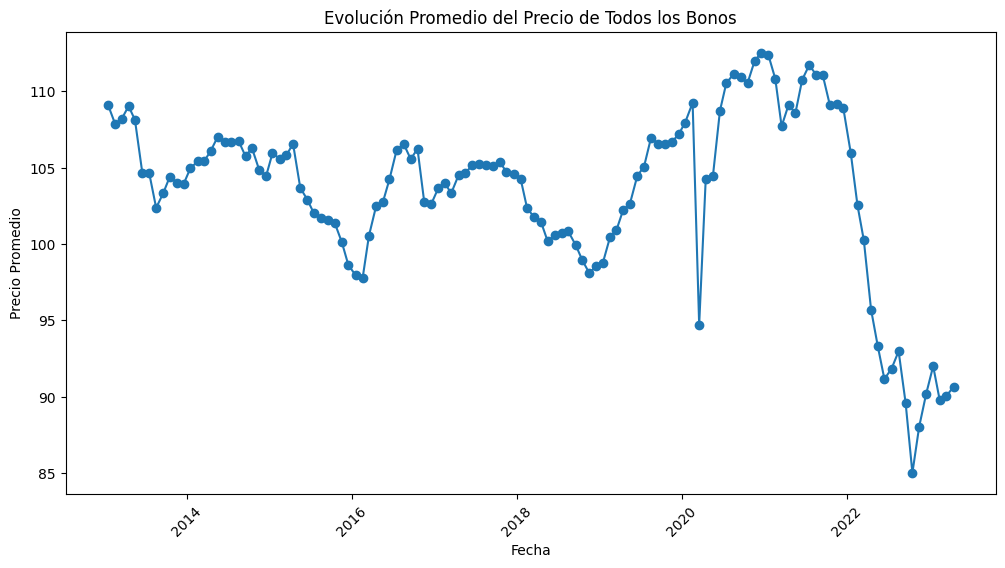

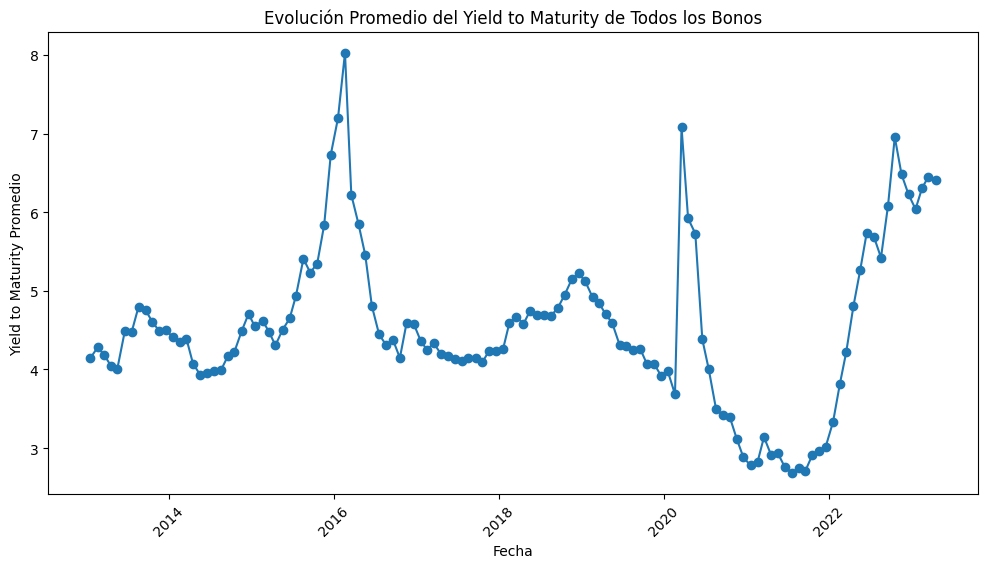

In [57]:
# Evolución promedio del precio de todos los bonos a lo largo del tiempo
monthly_avg_price = combined_df.groupby('Month')['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_price['Month'], monthly_avg_price['Price'], marker='o')
plt.title('Evolución Promedio del Precio de Todos los Bonos')
plt.xlabel('Fecha')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=45)
plt.show()

# Evolución promedio del rendimiento al vencimiento (Yield to Maturity)
monthly_avg_ytm = combined_df.groupby('Month')['Yield to Maturity'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_ytm['Month'], monthly_avg_ytm['Yield to Maturity'], marker='o')
plt.title('Evolución Promedio del Yield to Maturity de Todos los Bonos')
plt.xlabel('Fecha')
plt.ylabel('Yield to Maturity Promedio')
plt.xticks(rotation=45)
plt.show()

Explicaciones de las fluctuaciones del precio en función del contexto temporal
1.	Política Monetaria de la Reserva Federal (FED):
- 2013-2014: La Fed anunció la reducción gradual de su programa de compra de activos (tapering), lo que elevó las tasas de interés y redujo los precios de los bonos.
- 2015: La Fed aumentó las tasas de interés por primera vez desde la crisis financiera de 2008, lo que también contribuyó a la caída de los precios de los bonos.
2.	Crisis de los Mercados Emergentes (2015-2016):
- 2015: Las preocupaciones sobre el crecimiento económico en China y la crisis de los mercados emergentes provocaron una caída en los precios de los bonos debido al aumento del riesgo percibido.
- 2016: La incertidumbre económica global y los bajos precios del petróleo contribuyeron a la volatilidad en los mercados de bonos.
3.	Elección Presidencial en EE.UU. (2016):
- 2016: La elección de Donald Trump y la expectativa de políticas fiscales expansivas llevaron a un aumento en las tasas de interés, afectando negativamente los precios de los bonos.
4.	Pandemia de COVID-19 (2020):
- 2020: La pandemia de COVID-19 provocó una caída dramática en los precios de los bonos debido a la incertidumbre económica global y la demanda de activos de refugio seguro.
- La posterior intervención de los bancos centrales, incluyendo la Fed, con programas de compra de bonos y recortes de tasas de interés, ayudaron a estabilizar y eventualmente aumentar los precios de los bonos.
5.	Recuperación Económica y Política Monetaria (2021-2022):
- 2021: A medida que las economías comenzaron a recuperarse de la pandemia, las expectativas de inflación y las señales de la Fed sobre posibles aumentos de tasas de interés llevaron a una caída en los precios de los bonos.
- 2022: La guerra en Ucrania, junto con el aumento de las tasas de interés por parte de la Fed para combatir la alta inflación, continuó ejerciendo presión sobre los precios de los bonos.

[*********************100%%**********************]  1 of 1 completed

Rango de fechas de hYield: 2013-01-18 00:00:00 a 2023-04-19 00:00:00
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2013-01-31  1501.959961  1504.189941  1496.760010  1498.109985  1498.109985   
2013-02-28  1515.989990  1525.339966  1514.459961  1514.680054  1514.680054   
2013-03-31  1562.859985  1570.280029  1561.079956  1569.189941  1569.189941   
2013-04-30  1593.579956  1597.569946  1586.500000  1597.569946  1597.569946   
2013-05-31  1652.130005  1658.989990  1630.739990  1630.739990  1630.739990   

                Volume  
Date                    
2013-01-31  3999880000  
2013-02-28  3912320000  
2013-03-31  3304440000  
2013-04-30  3745070000  
2013-05-31  4099600000  
       Month       Price
0 2013-01-31  109.111487
1 2013-02-28  107.843714
2 2013-03-31  108.189727
3 2013-04-30  109.032142
4 2013-05-31  108.138308
       Month  Standardized_Price
0 2013-01-31       


/var/folders/w1/sdkgmjnn6h38t45w96vzq2h40000gn/T/ipykernel_29641/2023813727.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sp500 = sp500.resample('M').last()


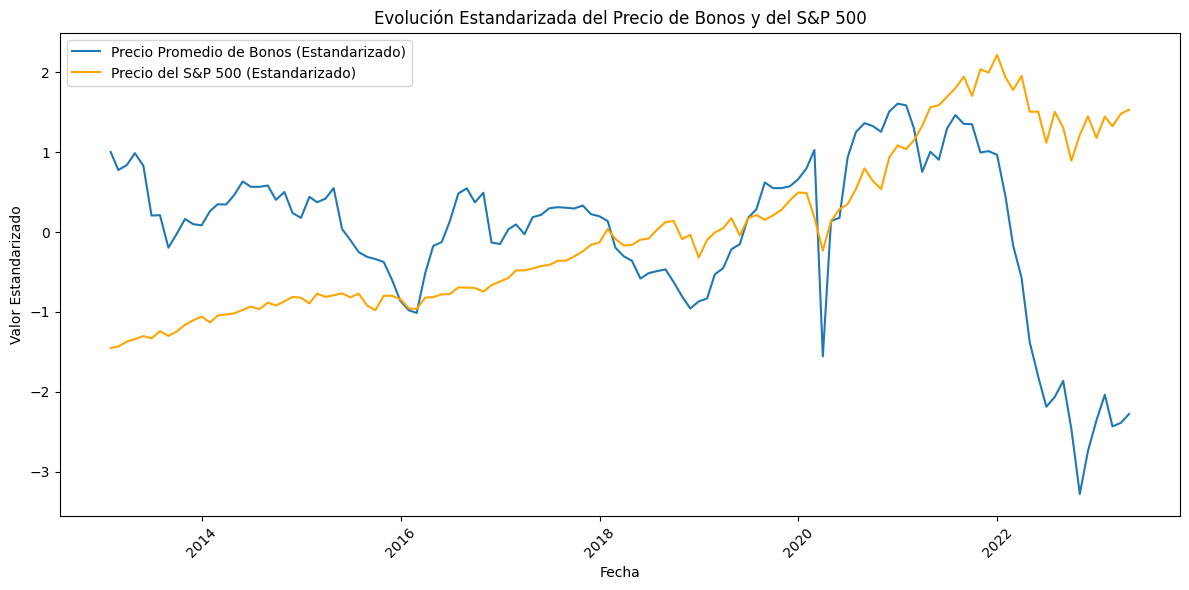

In [67]:
start_date = combined_df['Month'].min()
end_date = combined_df['Month'].max()
print(f"Rango de fechas de hYield: {start_date} a {end_date}")

sp500 = yf.download('^GSPC', start=start_date, end=end_date)
sp500 = sp500.resample('M').last()

print(sp500.head())

monthly_avg_price = combined_df.groupby('Month')['Price'].mean().reset_index()
monthly_avg_price['Month'] = monthly_avg_price['Month'] + pd.offsets.MonthEnd(0)
print(monthly_avg_price.head())


monthly_avg_price['Standardized_Price'] = (monthly_avg_price['Price'] - monthly_avg_price['Price'].mean()) / monthly_avg_price['Price'].std()
sp500['Standardized_Adj_Close'] = (sp500['Adj Close'] - sp500['Adj Close'].mean()) / sp500['Adj Close'].std()
print(monthly_avg_price[['Month', 'Standardized_Price']].head())
print(sp500[['Standardized_Adj_Close']].head())

junto_df = pd.merge(monthly_avg_price, sp500[['Standardized_Adj_Close']], left_on='Month', right_index=True, how='inner')
print(combined_df.head())

plt.figure(figsize=(12, 6))
plt.plot(junto_df['Month'], junto_df['Standardized_Price'], label='Precio Promedio de Bonos (Estandarizado)')
plt.plot(junto_df['Month'], junto_df['Standardized_Adj_Close'], color='orange', label='Precio del S&P 500 (Estandarizado)')
plt.title('Evolución Estandarizada del Precio de Bonos y del S&P 500')
plt.xlabel('Fecha')
plt.ylabel('Valor Estandarizado')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

             DFF
DATE            
2013-01-31  0.15
2013-02-28  0.14
2013-03-31  0.09
2013-04-30  0.14
2013-05-31  0.09
       Month       Price
0 2013-01-31  109.111487
1 2013-02-28  107.843714
2 2013-03-31  108.189727
3 2013-04-30  109.032142
4 2013-05-31  108.138308
       Month  Standardized_Price
0 2013-01-31            1.003210
1 2013-02-28            0.777884
2 2013-03-31            0.839382
3 2013-04-30            0.989108
4 2013-05-31            0.830243
            Standardized_FED_Rate
DATE                             
2013-01-31              -0.639050
2013-02-28              -0.647563
2013-03-31              -0.690125
2013-04-30              -0.647563
2013-05-31              -0.690125
           ISIN          Description  Ccy    Price        YTW       OAD  \
0  US852061AK63         S 9 11/15/18  USD  124.500   4.209298  4.750172   
1  US404121AC95     HCA 6 ½ 02/15/20  USD  113.750   4.229491  5.778464   
2  US761735AN93    PTVE 5 ¾ 10/15/20  USD  103.750   4.988087  5.28333

/var/folders/w1/sdkgmjnn6h38t45w96vzq2h40000gn/T/ipykernel_29641/4072046412.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fed_rate = fed_rate.resample('M').last()


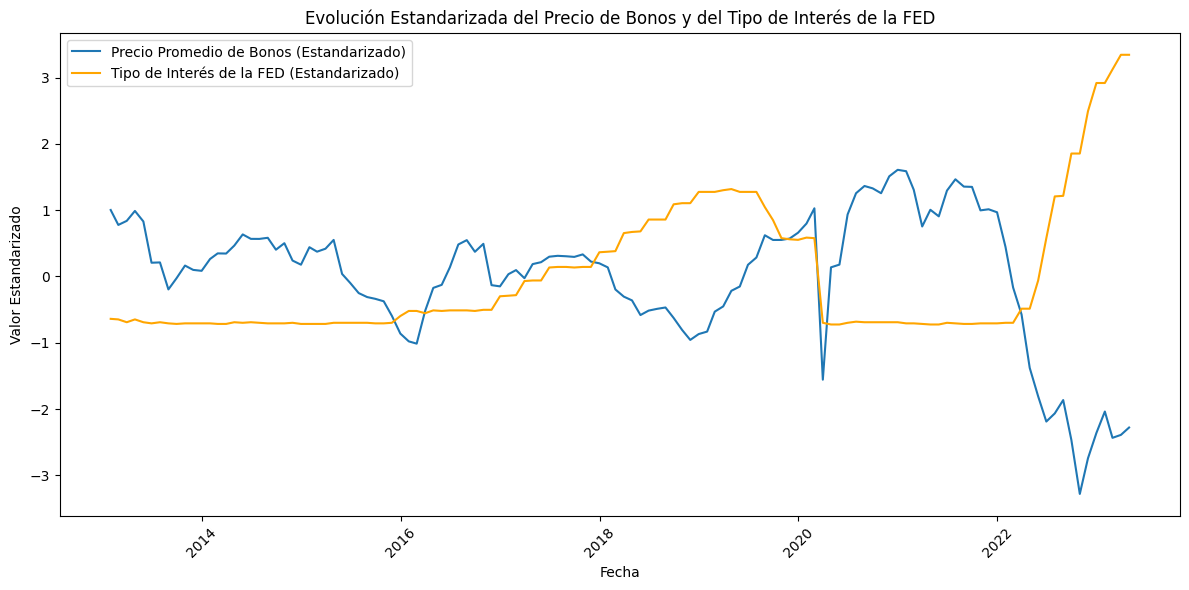

In [68]:
# Comparaciones entre el precio y el tipo de interés de la FED

# Datos FED
fed_rate = web.DataReader('DFF', 'fred', start_date, end_date)
fed_rate = fed_rate.resample('M').last()
print(fed_rate.head())


monthly_avg_price = combined_df.groupby('Month')['Price'].mean().reset_index()
monthly_avg_price['Month'] = monthly_avg_price['Month'] + pd.offsets.MonthEnd(0)
print(monthly_avg_price.head())

monthly_avg_price['Standardized_Price'] = (monthly_avg_price['Price'] - monthly_avg_price['Price'].mean()) / monthly_avg_price['Price'].std()
fed_rate['Standardized_FED_Rate'] = (fed_rate['DFF'] - fed_rate['DFF'].mean()) / fed_rate['DFF'].std()

print(monthly_avg_price[['Month', 'Standardized_Price']].head())
print(fed_rate[['Standardized_FED_Rate']].head())
junto_df = pd.merge(monthly_avg_price, fed_rate[['Standardized_FED_Rate']], left_on='Month', right_index=True, how='inner')
print(combined_df.head())

plt.figure(figsize=(12, 6))
plt.plot(junto_df['Month'], junto_df['Standardized_Price'], label='Precio Promedio de Bonos (Estandarizado)')
plt.plot(junto_df['Month'], junto_df['Standardized_FED_Rate'], color='orange', label='Tipo de Interés de la FED (Estandarizado)')
plt.title('Evolución Estandarizada del Precio de Bonos y del Tipo de Interés de la FED')
plt.xlabel('Fecha')
plt.ylabel('Valor Estandarizado')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

/var/folders/w1/sdkgmjnn6h38t45w96vzq2h40000gn/T/ipykernel_29641/1373345321.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fed_rate = fed_rate.resample('M').last()


             DFF
DATE            
2013-01-31  0.15
2013-02-28  0.14
2013-03-31  0.09
2013-04-30  0.14
2013-05-31  0.09
       Month  Yield to Maturity
0 2013-01-31           4.146383
1 2013-02-28           4.280422
2 2013-03-31           4.188123
3 2013-04-30           4.045586
4 2013-05-31           4.006641
       Month  Standardized_YTM
0 2013-01-31         -0.390707
1 2013-02-28         -0.259192
2 2013-03-31         -0.349753
3 2013-04-30         -0.489606
4 2013-05-31         -0.527818
            Standardized_FED_Rate
DATE                             
2013-01-31              -0.639050
2013-02-28              -0.647563
2013-03-31              -0.690125
2013-04-30              -0.647563
2013-05-31              -0.690125
           ISIN          Description  Ccy    Price        YTW       OAD  \
0  US852061AK63         S 9 11/15/18  USD  124.500   4.209298  4.750172   
1  US404121AC95     HCA 6 ½ 02/15/20  USD  113.750   4.229491  5.778464   
2  US761735AN93    PTVE 5 ¾ 10/15/20  US

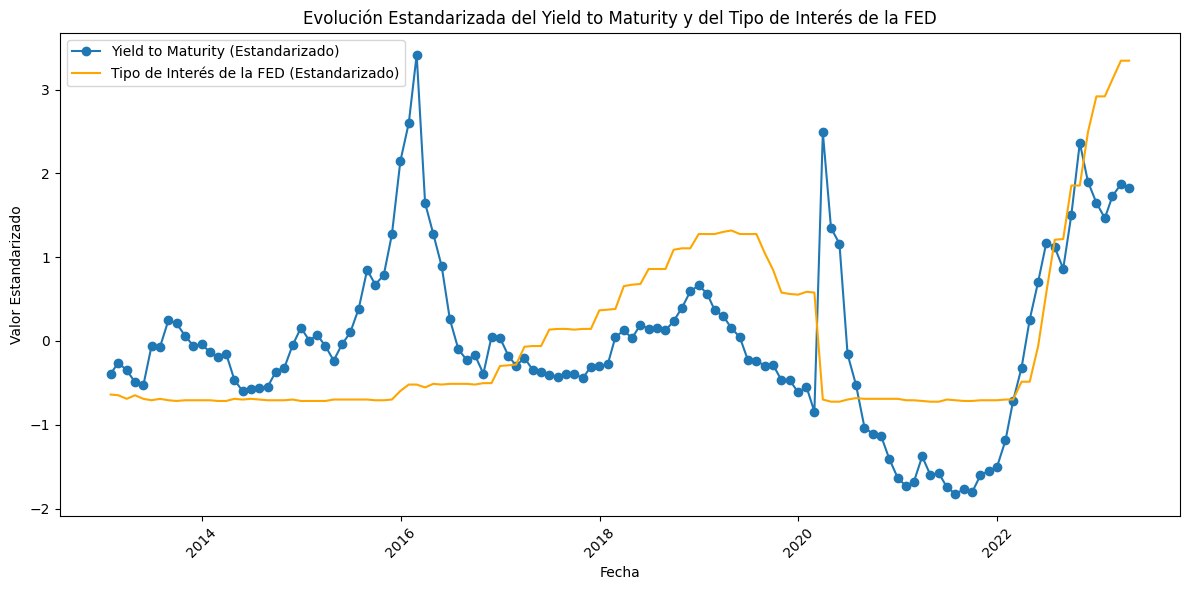

In [70]:
# Comparación YTM y tipos de interees

fed_rate = web.DataReader('DFF', 'fred', start_date, end_date)
fed_rate = fed_rate.resample('M').last()
print(fed_rate.head())

monthly_avg_ytm = combined_df.groupby('Month')['Yield to Maturity'].mean().reset_index()
monthly_avg_ytm['Month'] = monthly_avg_ytm['Month'] + pd.offsets.MonthEnd(0)
print(monthly_avg_ytm.head())
monthly_avg_ytm['Standardized_YTM'] = (monthly_avg_ytm['Yield to Maturity'] - monthly_avg_ytm['Yield to Maturity'].mean()) / monthly_avg_ytm['Yield to Maturity'].std()

fed_rate['Standardized_FED_Rate'] = (fed_rate['DFF'] - fed_rate['DFF'].mean()) / fed_rate['DFF'].std()
print(monthly_avg_ytm[['Month', 'Standardized_YTM']].head())
print(fed_rate[['Standardized_FED_Rate']].head())

junto_df = pd.merge(monthly_avg_ytm, fed_rate[['Standardized_FED_Rate']], left_on='Month', right_index=True, how='inner')

print(combined_df.head())
plt.figure(figsize=(12, 6))
plt.plot(junto_df['Month'], junto_df['Standardized_YTM'], marker='o', label='Yield to Maturity (Estandarizado)')
plt.plot(junto_df['Month'], junto_df['Standardized_FED_Rate'], color='orange', label='Tipo de Interés de la FED (Estandarizado)')
plt.title('Evolución Estandarizada del Yield to Maturity y del Tipo de Interés de la FED')
plt.xlabel('Fecha')
plt.ylabel('Valor Estandarizado')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

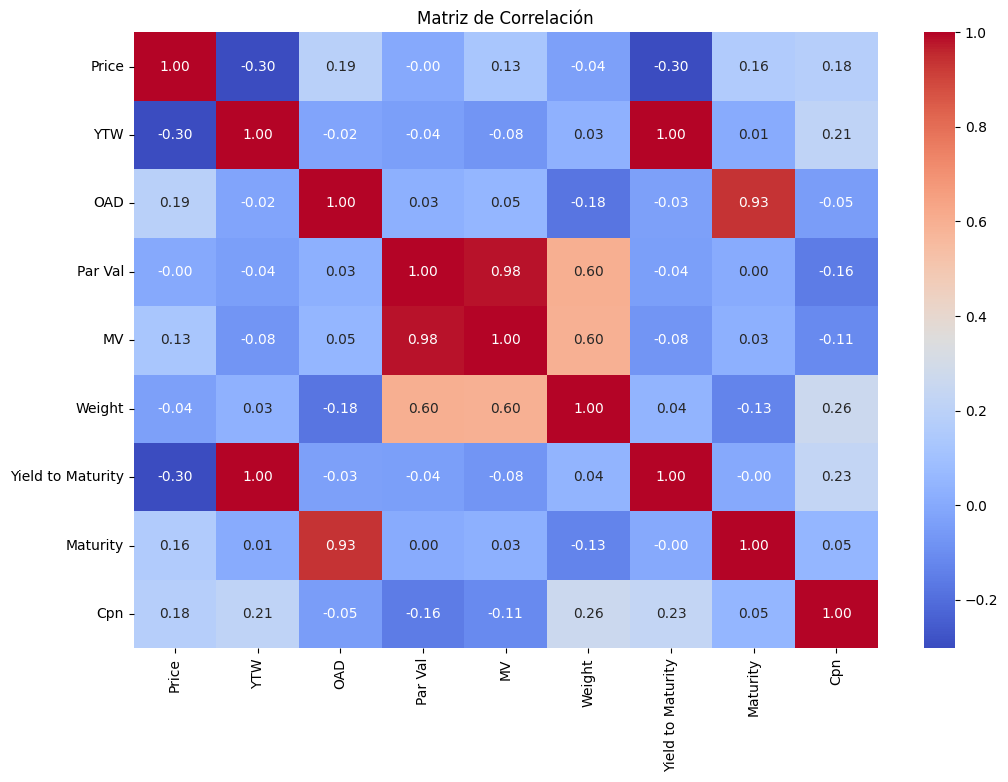

In [74]:
# Matriz de correlación
numeric_cols = ['Price', 'YTW', 'OAD', 'Par Val', 'MV', 'Weight', 'Yield to Maturity', 'Maturity', 'Cpn']
correlation_matrix = combined_df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación')
plt.show()


## Cartera Factor Investing

In [10]:
combined_df.head()

,ISIN,Description,Ccy,Price,YTW,OAD,Par Val,MV,Weight,Yield to Maturity,Issuer,Maturity,Maturity.1,Index Rating (String),BCLASS 2,Cpn,Payment rank,Month
0,US852061AK63,S 9 11/15/18,USD,124.500,4.209298,4.750172,3000000.0,3.783000e+06,0.325330,4.209298,SPRINT COMMUNICATIONS INC,5.822222,11/15/2018,BA3,INDUSTRIAL,9.000,Sr Unsecured,2013-01-18
1,US404121AC95,HCA 6 ½ 02/15/20,USD,113.750,4.229491,5.778464,3000000.0,3.495917e+06,0.300641,4.229491,HCA INC,7.072222,02/15/2020,BA2,INDUSTRIAL,6.500,1st lien,2013-01-18
2,US761735AN93,PTVE 5 ¾ 10/15/20,USD,103.750,4.988087,5.283333,3250000.0,3.429495e+06,0.294929,5.154282,REYNOLDS GRP ISS/REYNOLD,7.738889,10/15/2020,B1,INDUSTRIAL,5.750,1st lien,2013-01-18
3,US319963BB96,FDC 12 ⅝ 01/15/21,USD,107.250,11.105545,5.113684,2999994.0,3.411077e+06,0.293345,11.226144,FIRST DATA CORP,7.988889,01/15/2021,CAA1,INDUSTRIAL,12.625,Sr Unsecured,2013-01-18
4,US458204AH70,INTEL 11 ¼ 02/04/17,USD,106.125,4.812095,0.084089,2805000.0,3.111797e+06,0.267608,9.390606,INTELSAT LUXEMBOURG SA,4.041667,02/04/2017,CAA3,INDUSTRIAL,11.250,Sr Unsecured,2013-01-18


In [11]:
combined_df.shape

(992433, 18)

In [56]:
combined_df["Index Rating (String)"].values

array(['BA3', 'BA2', 'B1', ..., 'BAA1', 'AA2', 'A2'], dtype=object)

In [4]:
datos_bonos = pd.read_csv('./combined_df.csv')

In [16]:
combined_df_sampled = datos_bonos.sample(n=50000 , random_state=123)

In [58]:
#Crear Factores

combined_df['Size'] = combined_df.groupby('Month')['MV'].rank(ascending=False)

rating_map = {
    'AAA': 1,
    'AA1': 2, 'AA2': 3, 'AA3': 4,
    'A1': 5, 'A2': 6, 'A3': 7,
    'BAA1': 8, 'BAA2': 9, 'BAA3': 10,
    'BA1': 11, 'BA2': 12, 'BA3': 13,
    'B1': 14, 'B2': 15, 'B3': 16,
    'CAA1': 17, 'CAA2': 18, 'CAA3': 19,
    'CA': 20,
    'C': 21,
    'D': 22,
    'NR': 23
}

combined_df['Quality'] = combined_df['Index Rating (String)'].map(rating_map)

Average Portfolio Return for Size Strategy: 8.24%
Average Portfolio Return for Quality Strategy: 64.67%
Average Portfolio Return for Volatility Strategy: 32.63%
Average Index Return: 4.60%


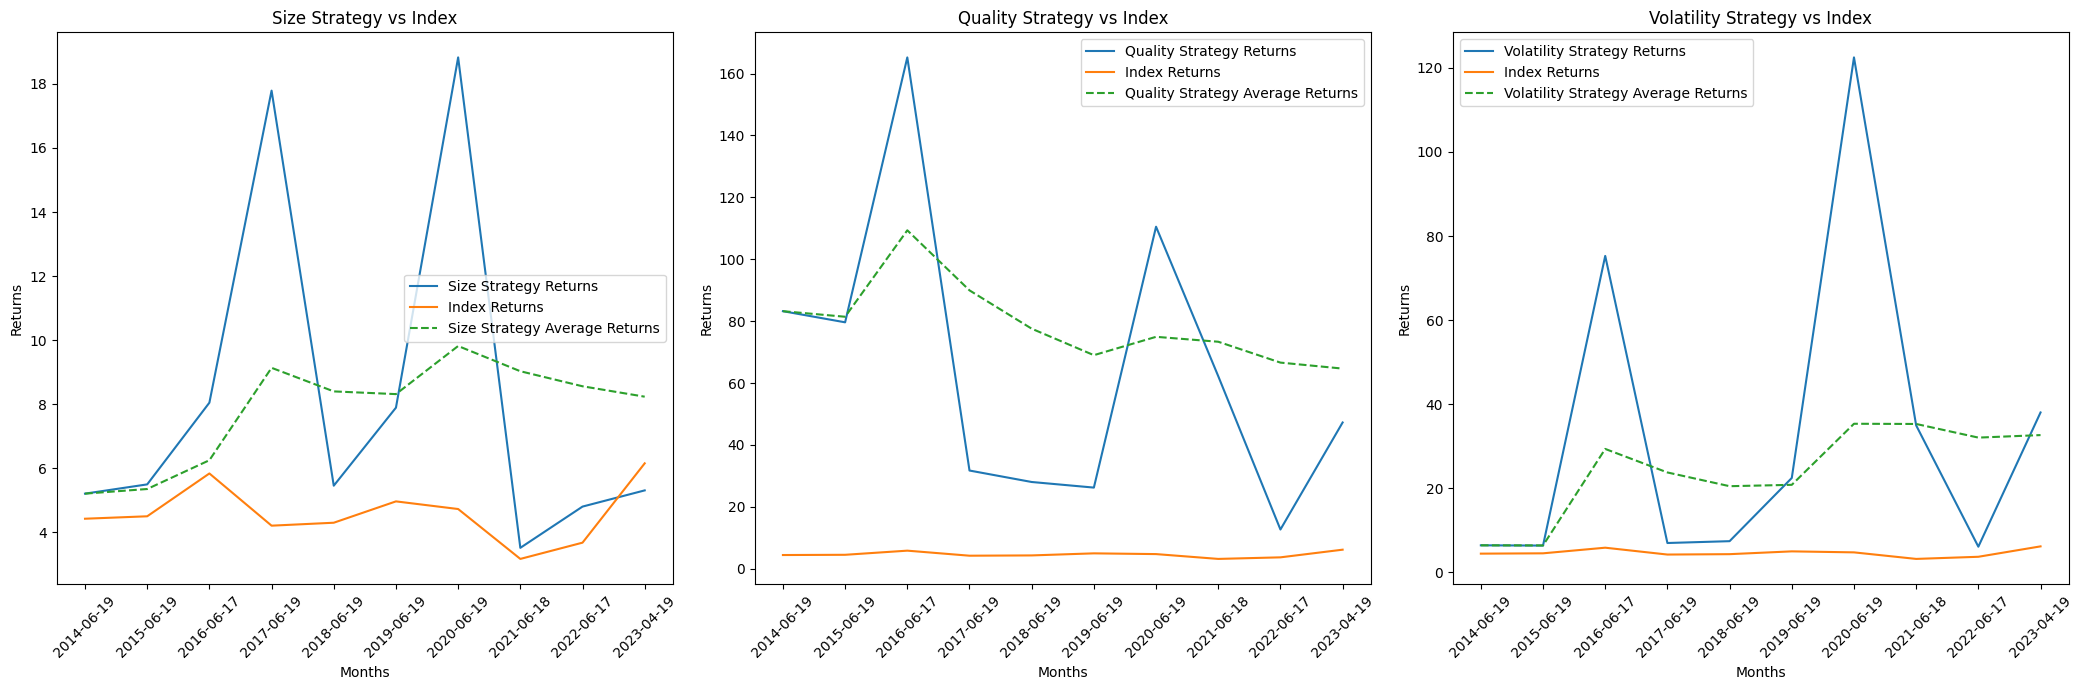

In [47]:

combined_df_sampled = datos_bonos.sample(n=50000, random_state=123)
combined_df_sampled.set_index('Month', inplace=True)

# Crear la estrategia de inversión

def create_strategy(df, factors, lookback_periods=6, holding_period=12):
    strategy = []
    months = df.index.unique().sort_values()
    portfolio_returns = []
    index_returns = []
    portfolio_average_returns = []
    test_period_months = []

    for i in range(lookback_periods, len(months), holding_period):
        train_period = months[i-lookback_periods:i]
        test_period = months[i:i+holding_period]
        
        train_data = df.loc[train_period]
        test_data = df.loc[test_period]
        X_train = train_data[factors]
        y_train = train_data['Yield to Maturity']
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        X_test = test_data[factors]
        test_data['Predicted_YTM'] = model.predict(X_test)
        selected_bonds = test_data.nlargest(10, 'Predicted_YTM')
        
        portfolio_return = selected_bonds['Yield to Maturity'].mean()
        portfolio_returns.append(portfolio_return)
        index_return = test_data['Yield to Maturity'].mean()
        index_returns.append(index_return)

        portfolio_average_returns.append(np.mean(portfolio_returns))
        
        strategy.append(selected_bonds)
        test_period_months.append(test_period[-1])  
    
    average_portfolio_return = np.mean(portfolio_returns)
    average_index_return = np.mean(index_returns)
    return pd.concat(strategy), average_portfolio_return, average_index_return, portfolio_returns, index_returns, portfolio_average_returns, test_period_months

factors = ['Size', 'Quality', 'Volatility']
combined_df_sampled = combined_df_sampled.dropna(subset=factors) 
size_strategy, size_avg_return, size_index_return, size_portfolio_returns, size_index_returns, size_portfolio_avg_returns, size_test_period_months = create_strategy(combined_df_sampled, ['Size'])
quality_strategy, quality_avg_return, quality_index_return, quality_portfolio_returns, quality_index_returns, quality_portfolio_avg_returns, quality_test_period_months = create_strategy(combined_df_sampled, ['Quality'])
volatility_strategy, volatility_avg_return, volatility_index_return, volatility_portfolio_returns, volatility_index_returns, volatility_portfolio_avg_returns, volatility_test_period_months = create_strategy(combined_df_sampled, ['Volatility'])

comparison_df_size = pd.DataFrame({
    'Portfolio_Returns': size_portfolio_returns,
    'Index_Returns': size_index_returns,
    'Portfolio_Average_Returns': size_portfolio_avg_returns
}, index=size_test_period_months)

comparison_df_quality = pd.DataFrame({
    'Portfolio_Returns': quality_portfolio_returns,
    'Index_Returns': quality_index_returns,
    'Portfolio_Average_Returns': quality_portfolio_avg_returns
}, index=quality_test_period_months)

comparison_df_volatility = pd.DataFrame({
    'Portfolio_Returns': volatility_portfolio_returns,
    'Index_Returns': volatility_index_returns,
    'Portfolio_Average_Returns': volatility_portfolio_avg_returns
}, index=volatility_test_period_months)

print(f"Average Portfolio Return for Size Strategy: {size_avg_return :.2f}%")
print(f"Average Portfolio Return for Quality Strategy: {quality_avg_return :.2f}%")
print(f"Average Portfolio Return for Volatility Strategy: {volatility_avg_return :.2f}%")
print(f"Average Index Return: {volatility_index_return :.2f}%")

# Visualización de la comparación de los rendimientos
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.plot(comparison_df_size.index, comparison_df_size['Portfolio_Returns'], label='Size Strategy Returns')
plt.plot(comparison_df_size.index, comparison_df_size['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_size.index, comparison_df_size['Portfolio_Average_Returns'], label='Size Strategy Average Returns', linestyle='--')
plt.title('Size Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(comparison_df_quality.index, comparison_df_quality['Portfolio_Returns'], label='Quality Strategy Returns')
plt.plot(comparison_df_quality.index, comparison_df_quality['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_quality.index, comparison_df_quality['Portfolio_Average_Returns'], label='Quality Strategy Average Returns', linestyle='--')
plt.title('Quality Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Portfolio_Returns'], label='Volatility Strategy Returns')
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Portfolio_Average_Returns'], label='Volatility Strategy Average Returns', linestyle='--')
plt.title('Volatility Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


In [57]:
combined_df_sampled = datos_bonos.sample(n=50000 , random_state=123)

combined_df_sampled.set_index('Month', inplace=True)

# Crear la estrategia de inversión con múltiples factores

def create_strategy(df, factors, lookback_periods=6, holding_period=18):
    strategy = []
    months = df.index.unique().sort_values()
    portfolio_returns = []
    index_returns = []
    portfolio_average_returns = []

    for i in range(lookback_periods, len(months), holding_period):
        train_period = months[i-lookback_periods:i]
        test_period = months[i:i+holding_period]
        
        train_data = df.loc[train_period]
        test_data = df.loc[test_period]
        X_train = train_data[factors]
        y_train = train_data['Yield to Maturity']
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        X_test = test_data[factors]
        test_data['Predicted_YTM'] = model.predict(X_test)
        
        selected_bonds = test_data.nlargest(10, 'Predicted_YTM')
        
        portfolio_return = selected_bonds['Yield to Maturity'].mean()
        portfolio_returns.append(portfolio_return)
        
        index_return = test_data['Yield to Maturity'].mean()
        index_returns.append(index_return)


        portfolio_average_returns.append(np.mean(portfolio_returns))
        
        strategy.append(selected_bonds)
    
    average_portfolio_return = np.mean(portfolio_returns)
    average_index_return = np.mean(index_returns)
    return pd.concat(strategy), average_portfolio_return, average_index_return, portfolio_returns, index_returns, portfolio_average_returns

factors = ['Size', 'Quality', 'Volatility']
combined_df_sampled = combined_df_sampled.dropna(subset=factors) 

strategy, avg_return, index_return, portfolio_returns, index_returns, portfolio_avg_returns = create_strategy(combined_df_sampled, factors)

comparison_df = pd.DataFrame({
    'Portfolio_Returns': portfolio_returns,
    'Index_Returns': index_returns,
    'Portfolio_Average_Returns': portfolio_avg_returns
})



Average Portfolio Return for Combined Strategy: 69.41%
Average Index Return for Combined Strategy: 4.67%


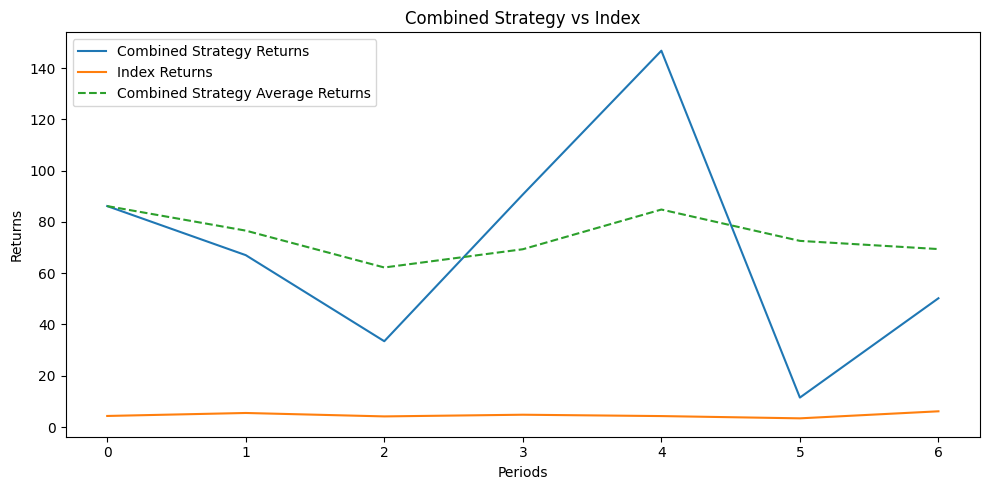

In [58]:
print(f"Average Portfolio Return for Combined Strategy: {avg_return :.2f}%")
print(f"Average Index Return for Combined Strategy: {index_return :.2f}%")

# Visualización de la comparación de los rendimientos
plt.figure(figsize=(10, 5))

plt.plot(comparison_df['Portfolio_Returns'], label='Combined Strategy Returns')
plt.plot(comparison_df['Index_Returns'], label='Index Returns')
plt.plot(comparison_df['Portfolio_Average_Returns'], label='Combined Strategy Average Returns', linestyle='--')
plt.title('Combined Strategy vs Index')
plt.xlabel('Periods')
plt.ylabel('Returns')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
combined_df_sampled = datos_bonos.sample(n=50000 , random_state=123)

combined_df_sampled.set_index('Month', inplace=True)

def create_strategy(df, factors, lookback_periods=6, holding_period=6):
    strategy = []
    months = df.index.unique().sort_values()
    portfolio_returns = []
    index_returns = []
    portfolio_average_returns = []

    for i in range(lookback_periods, len(months), holding_period):
        train_period = months[i-lookback_periods:i]
        test_period = months[i:i+holding_period]
        
        train_data = df.loc[train_period]
        test_data = df.loc[test_period]
        
        X_train = train_data[factors]
        y_train = train_data['Yield to Maturity']
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        X_test = test_data[factors]
        test_data['Predicted_YTM'] = model.predict(X_test)
        
        selected_bonds = test_data.nlargest(25, 'Predicted_YTM')
        
        portfolio_return = selected_bonds['Yield to Maturity'].mean()
        portfolio_returns.append(portfolio_return)
        
        index_return = test_data['Yield to Maturity'].mean()
        index_returns.append(index_return)

        portfolio_average_returns.append(np.mean(portfolio_returns))
        
        strategy.append(selected_bonds)
    
    average_portfolio_return = np.mean(portfolio_returns)
    average_index_return = np.mean(index_returns)
    portfolio_volatility = np.std(portfolio_returns)
    sharpe_ratio = (average_portfolio_return - average_index_return) / portfolio_volatility
    
    return pd.concat(strategy), average_portfolio_return, average_index_return, portfolio_returns, index_returns, portfolio_average_returns, sharpe_ratio

lookback_periods_list = [3, 6, 12]
holding_period_list = [12, 18, 24]

results = []

factors = ['Size', 'Quality', 'Volatility']
combined_df_sampled = combined_df_sampled.dropna(subset=factors)

for lookback in lookback_periods_list:
    for holding in holding_period_list:
        strategy, avg_return, index_return, portfolio_returns, index_returns, portfolio_avg_returns, sharpe_ratio = create_strategy(combined_df_sampled, factors, lookback_periods=lookback, holding_period=holding)
        
        results.append({
            'Lookback Period': lookback,
            'Holding Period': holding,
            'Average Portfolio Return': avg_return,
            'Average Index Return': index_return,
            'Portfolio Volatility': np.std(portfolio_returns),
            'Sharpe Ratio': sharpe_ratio
        })

results_df = pd.DataFrame(results)

best_combination = results_df.loc[results_df['Sharpe Ratio'].idxmax()]

print("\nBest Combination Based on Sharpe Ratio:")
print(best_combination)



Best Combination Based on Sharpe Ratio:
Lookback Period              6.000000
Holding Period              24.000000
Average Portfolio Return    64.585031
Average Index Return         4.570655
Portfolio Volatility        19.142531
Sharpe Ratio                 3.135133
Name: 5, dtype: float64


In [39]:
results_df

,Lookback Period,Holding Period,Average Portfolio Return,Average Index Return,Portfolio Volatility,Sharpe Ratio
0,3,12,73.533948,4.690211,60.141866,1.144689
1,3,18,67.836077,4.618095,55.510878,1.138840
2,3,24,96.664080,4.805027,73.698814,1.246412
3,6,12,75.684955,4.597648,50.198472,1.416125
4,6,18,69.408433,4.669116,40.939840,1.581328
5,6,24,101.311639,4.570655,61.378969,1.576126
6,12,12,49.708816,4.664775,43.619097,1.032668
7,12,18,90.062033,4.727089,62.002070,1.376324
8,12,24,102.176672,4.630996,68.043485,1.433578


Average Portfolio Return for Size Strategy: 8.24%
Average Portfolio Return for Quality Strategy: 64.67%
Average Portfolio Return for Volatility Strategy: 32.63%
Average Index Return: 4.60%


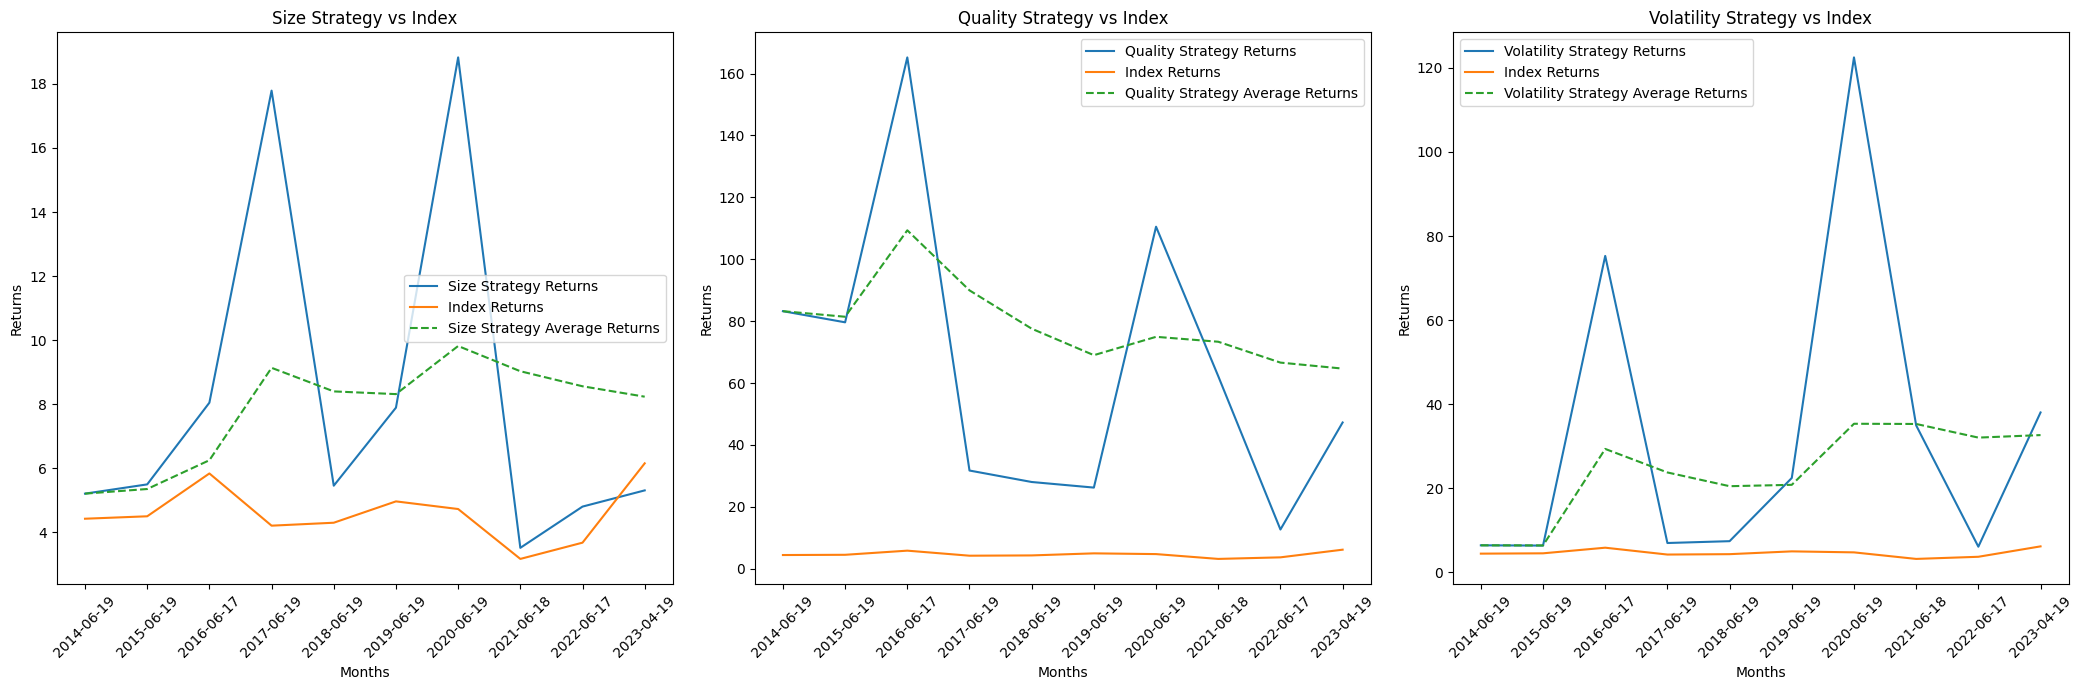

In [56]:

combined_df_sampled = datos_bonos.sample(n=50000, random_state=123)
combined_df_sampled_for_portfolio = datos_bonos.sample(n=100000, random_state=321)

combined_df_sampled.set_index('Month', inplace=True)

# Crear la estrategia de inversión
def create_strategy(df, factors, lookback_periods=6, holding_period=12):
    strategy = []
    months = df.index.unique().sort_values()
    portfolio_returns = []
    index_returns = []
    portfolio_average_returns = []
    test_period_months = []

    for i in range(lookback_periods, len(months), holding_period):
        train_period = months[i-lookback_periods:i]
        test_period = months[i:i+holding_period]
        
        train_data = df.loc[train_period]
        test_data = df.loc[test_period]
        
        # Entrenar el modelo Random Forest
        X_train = train_data[factors]
        y_train = train_data['Yield to Maturity']
        
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Predecir en el período de prueba
        X_test = test_data[factors]
        test_data['Predicted_YTM'] = model.predict(X_test)
        
        # Seleccionar los bonos con el YTM más alto predicho (long only)
        selected_bonds = test_data.nlargest(10, 'Predicted_YTM')
        
        # Calcular el retorno medio del portafolio
        portfolio_return = selected_bonds['Yield to Maturity'].mean()
        portfolio_returns.append(portfolio_return)
        
        # Calcular el retorno del índice para el período de prueba
        index_return = test_data['Yield to Maturity'].mean()
        index_returns.append(index_return)

        # Calcular el rendimiento promedio acumulado
        portfolio_average_returns.append(np.mean(portfolio_returns))
        
        strategy.append(selected_bonds)
        test_period_months.append(test_period[-1])  # Guardar el último mes del período de prueba
    
    average_portfolio_return = np.mean(portfolio_returns)
    average_index_return = np.mean(index_returns)
    return pd.concat(strategy), average_portfolio_return, average_index_return, portfolio_returns, index_returns, portfolio_average_returns, test_period_months

# Crear las estrategias para Size, Quality y Volatility
factors = ['Size', 'Quality', 'Volatility']
combined_df_sampled = combined_df_sampled.dropna(subset=factors)  # Asegurarse de no tener valores NaN en los factores
size_strategy, size_avg_return, size_index_return, size_portfolio_returns, size_index_returns, size_portfolio_avg_returns, size_test_period_months = create_strategy(combined_df_sampled, ['Size'])
quality_strategy, quality_avg_return, quality_index_return, quality_portfolio_returns, quality_index_returns, quality_portfolio_avg_returns, quality_test_period_months = create_strategy(combined_df_sampled, ['Quality'])
volatility_strategy, volatility_avg_return, volatility_index_return, volatility_portfolio_returns, volatility_index_returns, volatility_portfolio_avg_returns, volatility_test_period_months = create_strategy(combined_df_sampled, ['Volatility'])

# Comparar los rendimientos de la estrategia con el rendimiento del índice
comparison_df_size = pd.DataFrame({
    'Portfolio_Returns': size_portfolio_returns,
    'Index_Returns': size_index_returns,
    'Portfolio_Average_Returns': size_portfolio_avg_returns
}, index=size_test_period_months)

comparison_df_quality = pd.DataFrame({
    'Portfolio_Returns': quality_portfolio_returns,
    'Index_Returns': quality_index_returns,
    'Portfolio_Average_Returns': quality_portfolio_avg_returns
}, index=quality_test_period_months)

comparison_df_volatility = pd.DataFrame({
    'Portfolio_Returns': volatility_portfolio_returns,
    'Index_Returns': volatility_index_returns,
    'Portfolio_Average_Returns': volatility_portfolio_avg_returns
}, index=volatility_test_period_months)

print(f"Average Portfolio Return for Size Strategy: {size_avg_return :.2f}%")
print(f"Average Portfolio Return for Quality Strategy: {quality_avg_return :.2f}%")
print(f"Average Portfolio Return for Volatility Strategy: {volatility_avg_return :.2f}%")
print(f"Average Index Return: {volatility_index_return :.2f}%")

# Visualización de la comparación de los rendimientos
plt.figure(figsize=(21, 7))

plt.subplot(1, 3, 1)
plt.plot(comparison_df_size.index, comparison_df_size['Portfolio_Returns'], label='Size Strategy Returns')
plt.plot(comparison_df_size.index, comparison_df_size['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_size.index, comparison_df_size['Portfolio_Average_Returns'], label='Size Strategy Average Returns', linestyle='--')
plt.title('Size Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(comparison_df_quality.index, comparison_df_quality['Portfolio_Returns'], label='Quality Strategy Returns')
plt.plot(comparison_df_quality.index, comparison_df_quality['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_quality.index, comparison_df_quality['Portfolio_Average_Returns'], label='Quality Strategy Average Returns', linestyle='--')
plt.title('Quality Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Portfolio_Returns'], label='Volatility Strategy Returns')
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Index_Returns'], label='Index Returns')
plt.plot(comparison_df_volatility.index, comparison_df_volatility['Portfolio_Average_Returns'], label='Volatility Strategy Average Returns', linestyle='--')
plt.title('Volatility Strategy vs Index')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
/var/folders/w1/sdkgmjnn6h38t45w96vzq2h40000gn/T/ipykernel_33771/626703267.py:16: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_return = sp500_data['Cumulative Return'].resample('Y').last()


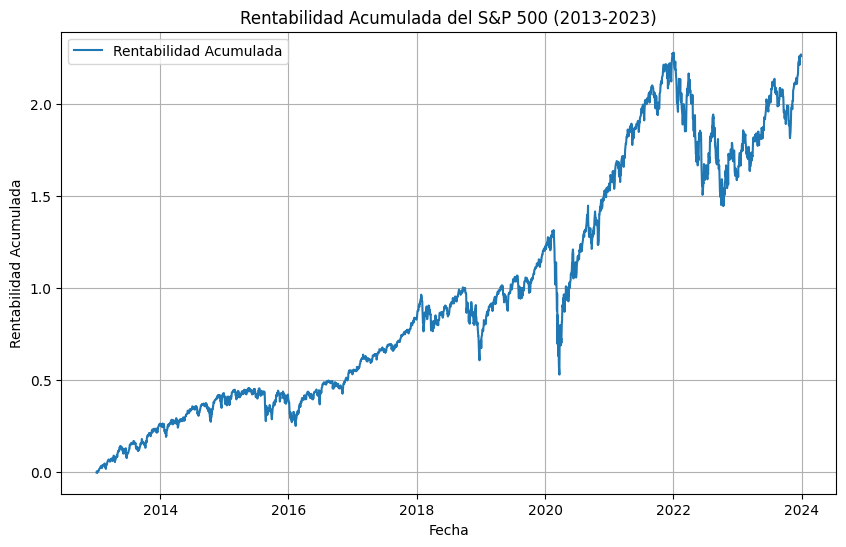

La rentabilidad media acumulada anual del S&P 500 entre 2013 y 2023 es: 109.70%


In [59]:
sp500_data = yf.download('^GSPC', start='2013-01-01', end='2023-12-31')
sp500_data['Daily Return'] = sp500_data['Adj Close'].pct_change()


sp500_data['Cumulative Return'] = (1 + sp500_data['Daily Return']).cumprod() - 1
annual_return = sp500_data['Cumulative Return'].resample('Y').last()
plt.figure(figsize=(10, 6))
plt.plot(sp500_data.index, sp500_data['Cumulative Return'], label='Rentabilidad Acumulada')
plt.title('Rentabilidad Acumulada del S&P 500 (2013-2023)')
plt.xlabel('Fecha')
plt.ylabel('Rentabilidad Acumulada')
plt.legend()
plt.grid(True)
plt.show()

mean_annual_return = np.mean(annual_return)
print(f"La rentabilidad media acumulada anual del S&P 500 entre 2013 y 2023 es: {mean_annual_return:.2%}")


In [65]:
datos_bonos['ISIN'].nunique()

22784